In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import rqpy as rp

In [42]:
!pwd

/Users/cwfink/Documents/School/UC_Berkeley/Research/CDMS/Analysis/COVID-19


In [30]:
path = '/Users/cwfink/Documents/School/UC_Berkeley/Research/CDMS/'+\
'python_scripts/repositories/COVID-19/csse_covid_19_data/csse_covid_19_time_series/'
confirmed_file = 'time_series_covid19_confirmed_US.csv'
deaths_file = 'time_series_covid19_deaths_US.csv'
#recovered_file = 'time_series_covid19_recovered_US.csv'

In [31]:
confirmed = pd.read_csv(path+confirmed_file)#, parse_dates=True, date_parser=pd.to_datetime)
deaths = pd.read_csv(path+deaths_file).drop(columns=['Population'])
#dates =  pd.to_datetime(confirmed.columns.values[11:])
#recovered = pd.read_csv(path+recovered_file)

In [32]:
def _days_since(cut, df, threshold):
    """
    Helper function to calculate days since a defined threshold of 
    cases
    """
    #cases = df.values
    dates =  pd.to_datetime(confirmed.columns.values[11:])
    new_cases = df[cut].values[...,11:].sum(axis=0)
    new_cut = new_cases > threshold
    new_dates = ((dates[new_cut] - dates[new_cut][0]).total_seconds()/(3600*24)).astype(int)
    new_cases = new_cases[new_cut]
    
    return new_dates.astype(np.float64), new_cases.astype(np.float64), new_cut, dates
    
    
def _plot(x, y_cases, y_deaths, dates, lgcdate, threshold, SIP, SIP_day, logplot, region, fit=False, **kwargs, ):
    """
    Helper function to plot totals and rates,
    as well as splinefits to data
    """
    
    grad_cases = np.gradient(y_cases, x)
    grad_deaths = np.gradient(y_deaths, x)
    
    
        
    if kwargs:
        sav_cases = savgol_filter(y_cases, **kwargs)
        sav_grad_cases = savgol_filter(grad_cases, **kwargs)
        sav_deaths = savgol_filter(y_deaths, **kwargs)
        sav_grad_deaths = savgol_filter(grad_deaths, **kwargs)
    else:
        sav_cases = savgol_filter(y_cases, window_length=5, polyorder=3)
        sav_grad_cases = savgol_filter(grad_cases, window_length=5, polyorder=3)
        sav_deaths = savgol_filter(y_deaths, window_length=5, polyorder=3)
        sav_grad_deaths = savgol_filter(grad_deaths, window_length=5, polyorder=3)
    
    fig, ax = plt.subplots(1,3, figsize=(15, 5))
    if lgcdate:
        xdata = dates
        fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
        ax[0].set_xlabel('Date')
        ax[1].set_xlabel('Date')
        ax[2].set_xlabel('Date')
        
    else:
        xdata = x
        ax[0].set_xlabel(f'Days Since First {threshold} Cases')
        ax[1].set_xlabel(f'Days Since First {threshold} Cases')
        ax[2].set_xlabel(f'Days Since First {threshold} Cases')
    
    if (fit & (SIP_day is not None)):
        
        ind1 = np.where(x > SIP_day)[0][0]
        ind0 = np.where(x >= SIP_day-14)[0][0]
        
        #print(ind0, ind1, xdata[ind0], xdata[ind1])
        
        p = np.polyfit(x[ind0:ind1], np.log(y_cases[ind0:ind1]), 1)
        poly = np.poly1d(p)
        
        ax[0].plot(xdata[ind0:], np.exp(poly(x[ind0:])), label='Projection with no SIP', 
                  zorder=100, color = 'xkcd:green', linewidth=3.5, linestyle = '-')
    
    ax[0].set_title('Total Number of Confirmed Cases')
    ax[0].plot(xdata,y_cases, linewidth=2.5, color='k', label='Number of Cases')
    ax[0].plot(xdata, sav_cases,linewidth=2.5, color='k', linestyle='--', alpha=0.5, label='Filtered')
    ax[0].tick_params('y', colors = 'k')
    ax[0].set_ylabel('Number of Cases')
    
    if SIP is not None:
        if lgcdate:
            ax[0].axvline(SIP, linestyle = ':', label='Shelter-in-place order')
            ax[1].axvline(SIP, linestyle = ':', label='Shelter-in-place order')
            ax[2].axvline(SIP, linestyle = ':', label='Shelter-in-place order')
        else:
            ax[0].axvline(SIP_day, linestyle = ':', label='Shelter-in-place order')
            ax[1].axvline(SIP_day, linestyle = ':', label='Shelter-in-place order')
            ax[2].axvline(SIP_day, linestyle = ':', label='Shelter-in-place order')
    ax[0].legend()
    if logplot:
        ax[0].set_yscale('log')
        #ax0.set_yscale('log')
        
        
    ax[1].set_title('Daily Rate of Number of Confirmed Cases')
    ax[1].plot(xdata, grad_cases,linewidth=2.5, color='k', label='New Cases Per Day')
    ax[1].plot(xdata, sav_grad_cases,linewidth=2.5, color='k', linestyle='--', alpha=0.5, label='Filtered')

    
    if logplot:
        ax[1].set_yscale('log')
    ax[1].set_ylabel('Number of New Cases per Day')
    ax[1].legend()
    
    

        
    ax[2].set_title('Mortality Rate')
    ax[2].plot(xdata,y_deaths, linewidth=2.5, color='k', label='Number of Cases')
    ax[2].plot(xdata, sav_deaths,linewidth=2.5, color='k', linestyle='--', alpha=0.5, label='Filtered')
    ax[2].tick_params('y', colors = 'k')
    ax[2].set_ylabel('Mortality Rate [\%]')

    ax[2].legend()
    fig.suptitle(f'COVID-19 Cases for {region}', fontsize=15)  
    #fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    #fig.tight_layout()
    
def make_plots(cut, cases_df=confirmed, deaths_df=deaths, SIP=None, threshold=50, lgcdate=False,region=None,
               logplot=False, fit=False, **kwargs):
    
    x, y_cases, c, dates = _days_since(cut=cut, df=cases_df, threshold=threshold)
    y_deaths = deaths_df[cut].values[...,11:].sum(axis=0)[c]
    y_deaths /= y_cases
    if SIP is not None:
        SIP_day = (SIP - dates[c].values[0]).astype('timedelta64[D]').astype('int')
    else: 
        SIP_day = None
        #print(SIP_day)
    _plot(x=x, y_cases=y_cases, y_deaths=y_deaths*100, dates=dates[c], SIP=SIP, SIP_day=SIP_day, 
          lgcdate=lgcdate, threshold=threshold, logplot=logplot, region=region, fit=fit, **kwargs)
    

In [33]:
region = 'Bay Area'
state = 'Washington'
all_us = np.ones(len(confirmed), dtype=bool)

alameda = confirmed.Admin2 == 'Alameda'
santa_clara = confirmed.Admin2 == 'Santa Clara'
santa_cruz = confirmed.Admin2 == 'Santa Cruz'
marin = confirmed.Admin2 == 'Marin'
contra_costa = confirmed.Admin2 == 'Contra Costa'
solano =  confirmed.Admin2 == 'Solano'
san_mateo = confirmed.Admin2 == 'san_mateo'
sf = confirmed.Admin2 == 'San Francisco'
napa =  confirmed.Admin2 == 'Napa'
sonoma = confirmed.Admin2 == 'Sonoma'

county_cut = alameda | san_mateo | santa_clara | santa_cruz | marin | contra_costa | sf | napa | sonoma | solano


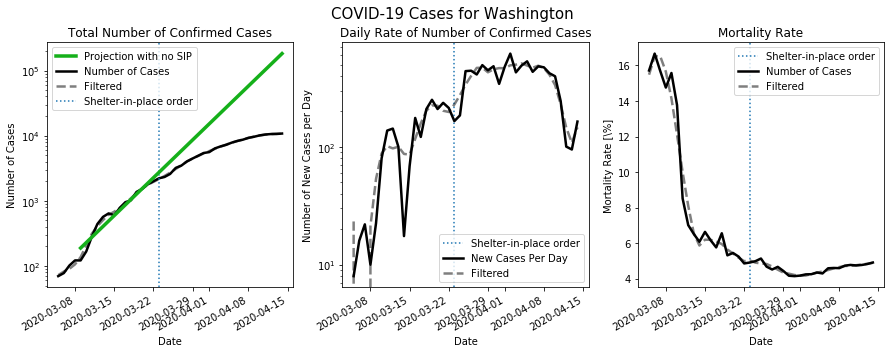

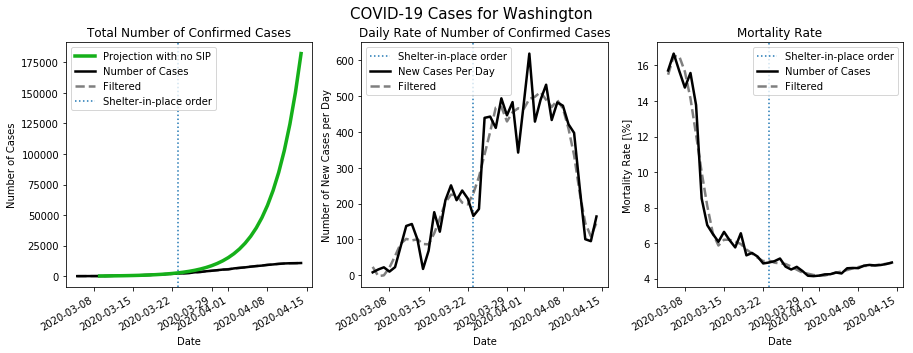

In [34]:
sip = np.datetime64('2020-03-16') #bay
#sip = np.datetime64('2020-03-22') #ny
#sip = np.datetime64('2020-03-28') #ak
sip = np.datetime64('2020-03-23') #wa

state = 'Washington'
state_cut = confirmed.Province_State == state

make_plots(cut=state_cut, lgcdate=True,
           logplot=True, region=state, SIP=sip, 
           fit=True, window_length=9, polyorder=3)
make_plots(cut=state_cut, lgcdate=True,
           logplot=False, region=state, SIP=sip, 
           fit=True, window_length=9, polyorder=3)


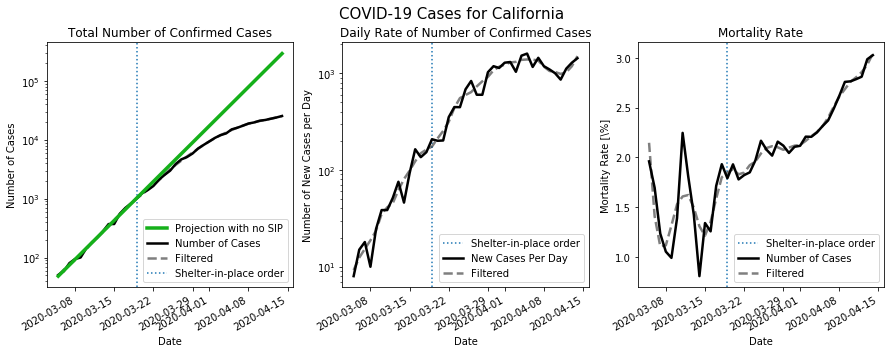

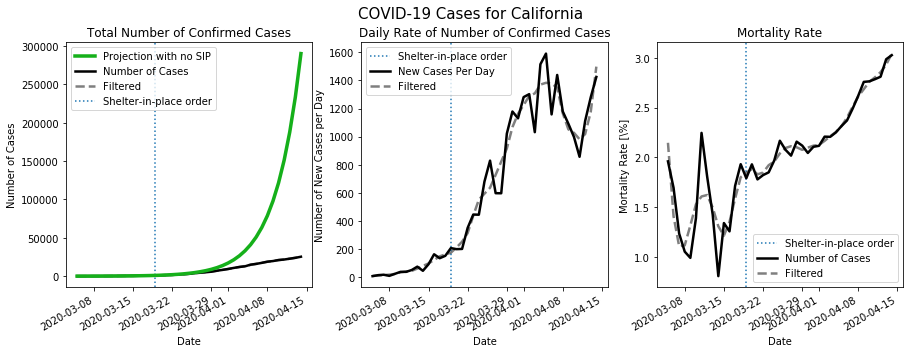

In [35]:

sip = np.datetime64('2020-03-19') #ca

region = 'Bay Area'
state = 'California'


alameda = confirmed.Admin2 == 'Alameda'

state_cut = confirmed.Province_State == state


make_plots(cut=state_cut, lgcdate=True,
           logplot=True, region=state, SIP=sip, 
           fit=True, window_length=9, polyorder=3)
make_plots(cut=state_cut, lgcdate=True,
           logplot=False, region=state, SIP=sip, 
           fit=True, window_length=9, polyorder=3)

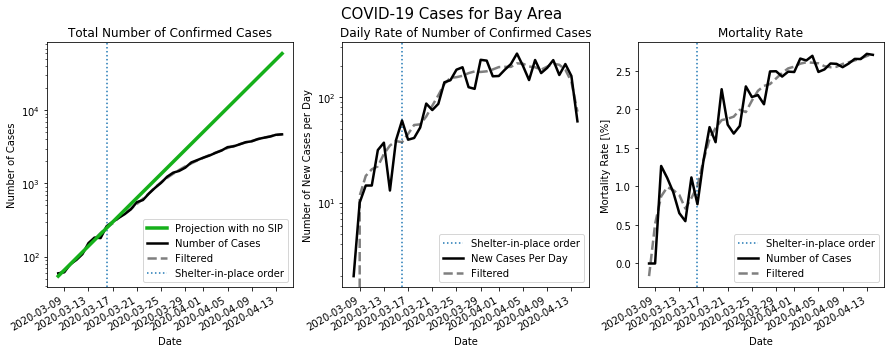

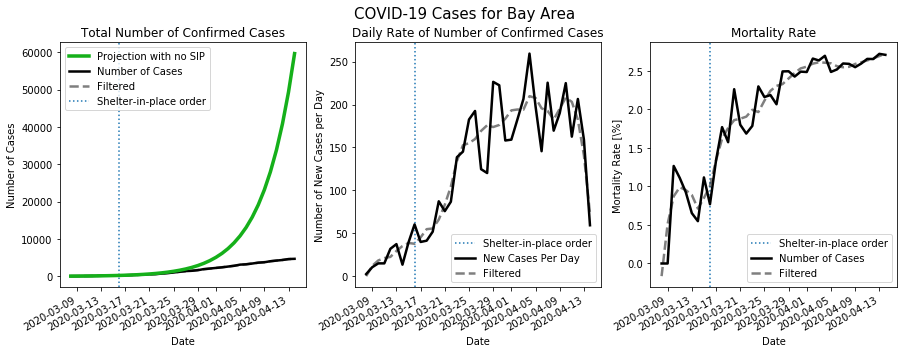

In [36]:
sip = np.datetime64('2020-03-16') #bay



make_plots(cut=county_cut, lgcdate=True,
           logplot=True, region=region, SIP=sip, 
           fit=True, window_length=9, polyorder=3)
make_plots(cut=county_cut, lgcdate=True,
           logplot=False, region=region, SIP=sip, 
           fit=True, window_length=9, polyorder=3)

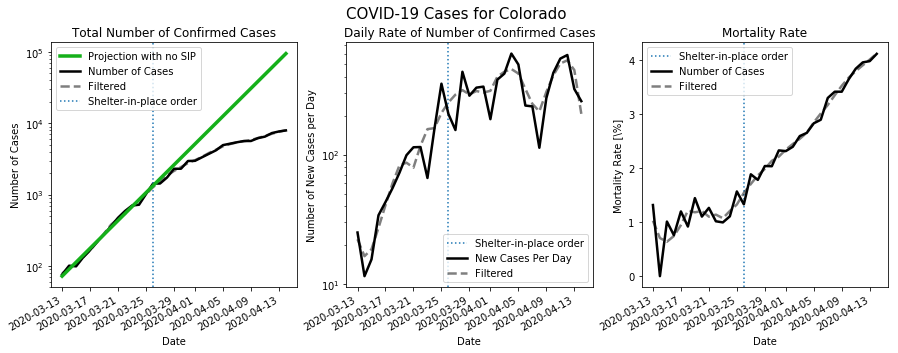

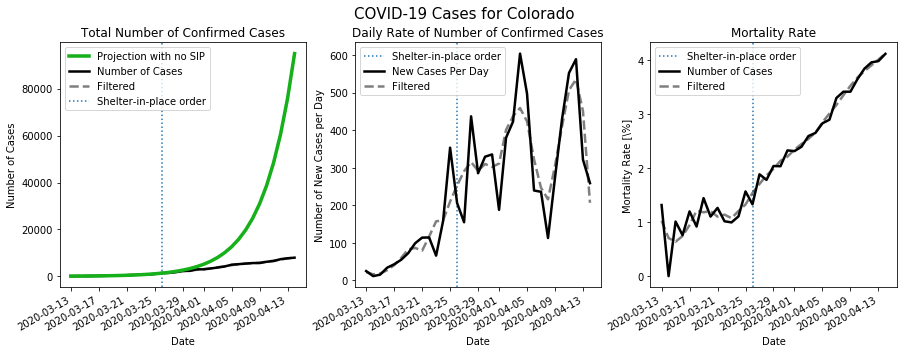

In [37]:
sip = np.datetime64('2020-03-26') #co


state = 'Colorado'




state_cut = confirmed.Province_State == state


make_plots(cut=state_cut, lgcdate=True,
           logplot=True, region=state, SIP=sip, 
           fit=True, window_length=9, polyorder=3)
make_plots(cut=state_cut, lgcdate=True,
           logplot=False, region=state, SIP=sip, 
           fit=True, window_length=9, polyorder=3)

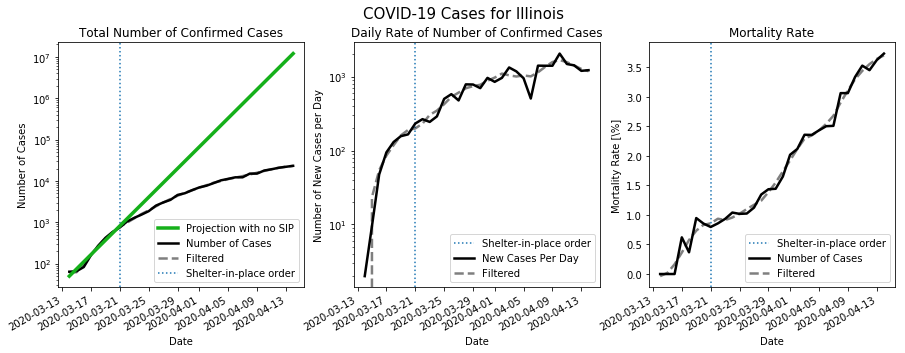

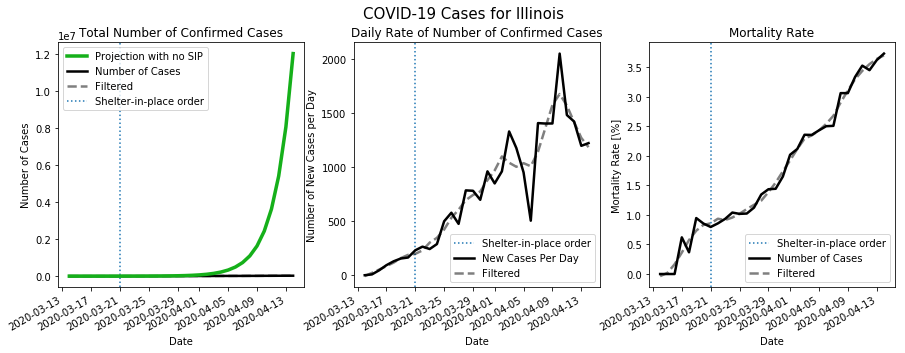

In [38]:
sip = np.datetime64('2020-03-21') #co


state = 'Illinois'




state_cut = confirmed.Province_State == state


make_plots(cut=state_cut, lgcdate=True,
           logplot=True, region=state, SIP=sip, 
           fit=True, window_length=9, polyorder=3)
make_plots(cut=state_cut, lgcdate=True,
           logplot=False, region=state, SIP=sip, 
           fit=True, window_length=9, polyorder=3)


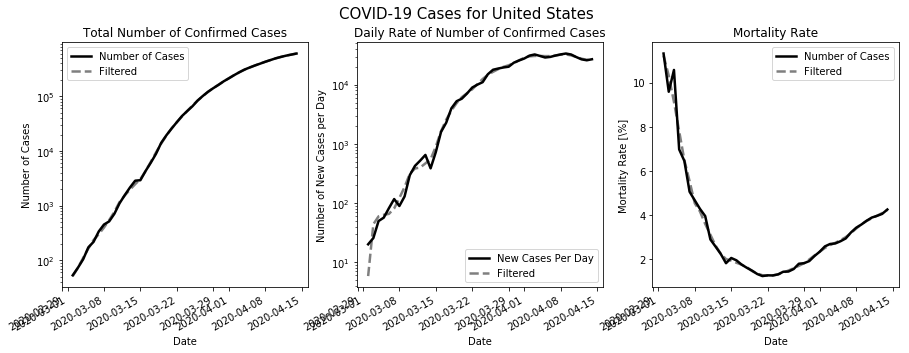

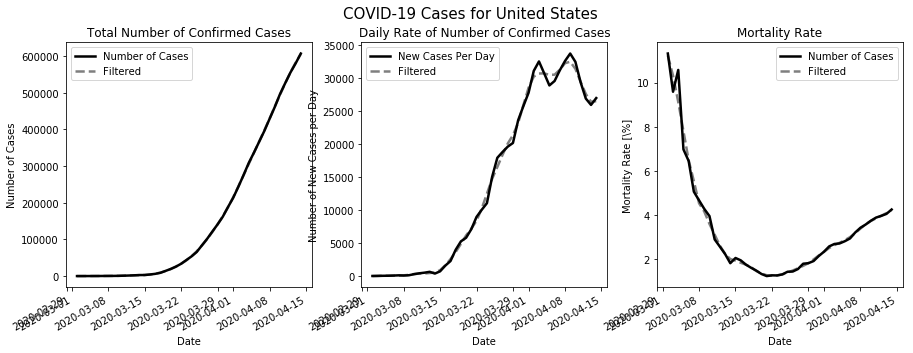

In [39]:

make_plots(cut=all_us, lgcdate=True,
           logplot=True, region='United States', SIP=None, 
           fit=False, window_length=9, polyorder=3)
make_plots(cut=all_us, lgcdate=True,
           logplot=False, region='United States', SIP=None, 
           fit=False, window_length=9, polyorder=3)

In [40]:
confirmed.keys().values[-1]

'4/14/20'

In [41]:
deaths[confirmed.keys().values[-1]].sum()/confirmed[confirmed.keys().values[-1]].sum()*100

4.252544000210799